### Pemeriksaan Environment

### Periksa Penggunaan GPU oleh Tensorflow

In [4]:
# import tensorflow as tf

# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# if tf.config.list_physical_devices('GPU'):
#     print("TensorFlow is using GPU.")
# else:
#     print("TensorFlow is not using GPU.")

### Install Dependency jika belum diinstal pada environment

In [5]:
# %pip install tensorflow
# %pip install keras_tuner
# %pip install streamlit
# %pip install matplotlib

### Periksa Dataset

Periksa gambar yang mungkin menyebabkan error pada image_dateset_from_directory.

In [6]:
import os
import tensorflow as tf

DATA_DIR = '/mnt/g/My Drive/college/Smt4/PCP/DatasetTekstur'
print("Mencari file penyebab error menggunakan TensorFlow...")

problematic_file = None

for class_folder in os.listdir(DATA_DIR):
    class_path = os.path.join(DATA_DIR, class_folder)
    if not os.path.isdir(class_path):
        continue
        
    for filename in os.listdir(class_path):
        file_path = os.path.join(class_path, filename)
        try:
            # Coba baca dan decode gambar menggunakan TensorFlow
            img_bytes = tf.io.read_file(file_path)
            decoded_img = tf.io.decode_image(img_bytes)
        except tf.errors.InvalidArgumentError as e:
            # Jika error ini muncul, kita menemukan pelakunya!
            problematic_file = file_path
            print(f"\n---> DITEMUKAN! File penyebab masalah adalah: {problematic_file}")
            print(f"Error: {e}")
            break # Hentikan pencarian
    if problematic_file:
        break

if not problematic_file:
    print("\nTidak ditemukan file spesifik yang menyebabkan error InvalidArgument.")

Mencari file penyebab error menggunakan TensorFlow...


I0000 00:00:1750660741.264451     615 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3620 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6



---> DITEMUKAN! File penyebab masalah adalah: /mnt/g/My Drive/college/Smt4/PCP/DatasetTekstur/batu/desktop.ini
Error: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 


2025-06-23 14:39:06.742281: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Unknown image file format. One of JPEG, PNG, GIF, BMP required.


### Import Semua Package

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import classification_report, confusion_matrix

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


### Konfigurasi Parameter Utama

Mendefinisikan semua parameter penting di satu tempat agar mudah diubah.

In [8]:
# Ganti dengan path ke direktori dataset Anda
from pathlib import Path
DATA_DIR = Path("/mnt/g/My Drive/college/Smt4/PCP/DatasetTekstur")

# Parameter untuk pemrosesan gambar dan pelatihan
IMG_SIZE = (512, 512)
BATCH_SIZE = 32
CLASSES = ['batu', 'kain', 'kayu']

### Memuat Dataset dan Membagi Dataset Training dan Validation

In [9]:
# Muat dataset dari direktori, langsung bagi menjadi train dan validation
# 80% data untuk training, 20% untuk validasi sementara
initial_train_ds, initial_val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    class_names=CLASSES,
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset="both",
    seed=1337,
    batch_size=BATCH_SIZE,
)

# Ambil 50% dari set validasi sementara untuk dijadikan set test final
# Sisanya (50%) akan menjadi set validasi yang sebenarnya
val_batches = tf.data.experimental.cardinality(initial_val_ds)
test_ds = initial_val_ds.take(val_batches // 2)
val_ds = initial_val_ds.skip(val_batches // 2)

print(f"Jumlah batch di set Pelatihan: {tf.data.experimental.cardinality(initial_train_ds)}")
print(f"Jumlah batch di set Validasi: {tf.data.experimental.cardinality(val_ds)}")
print(f"Jumlah batch di set Pengujian: {tf.data.experimental.cardinality(test_ds)}")

# Optimalkan performa dataset
AUTOTUNE = tf.data.AUTOTUNE
train_ds = initial_train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 300 files belonging to 3 classes.
Using 240 files for training.
Using 60 files for validation.
Jumlah batch di set Pelatihan: 8
Jumlah batch di set Validasi: 1
Jumlah batch di set Pengujian: 1


### Membuat layer augmentasi data

Lapisan ini akan diterapkan pada gambar selama pelatihan untuk menciptakan variasi dan mencegah model menghafal.

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
], name="data_augmentation")

### Membangun model baru dengan transfer learning bersama model EfficientNetB0

In [11]:
# Pra-pemrosesan khusus untuk EfficientNet
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

# Muat model dasar (base model) tanpa lapisan klasifikasi di atasnya
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=IMG_SIZE + (3,),
    include_top=False,  # Jangan sertakan lapisan Dense terakhir
    weights='imagenet'
)

# Bekukan (freeze) lapisan-lapisan di base model agar tidak ikut terlatih di awal
base_model.trainable = False

# Buat arsitektur model lengkap
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False) # Mode inference untuk base model
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(len(CLASSES), activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# Tampilkan arsitektur model
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 16, 16, 1280)   │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### Pelatihan Tahap 1 - Feature Extraction

In [12]:
initial_epochs = 20

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

print("Memulai Pelatihan Tahap 1 (Feature Extraction)...")
history = model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=val_ds
)

Memulai Pelatihan Tahap 1 (Feature Extraction)...
Epoch 1/20


I0000 00:00:1750660762.221171    4470 cuda_dnn.cc:529] Loaded cuDNN version 90300


8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3329 - loss: 1.1579 - val_accuracy: 0.6786 - val_loss: 0.8202
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 663ms/step - accuracy: 0.7244 - loss: 0.7673 - val_accuracy: 0.9643 - val_loss: 0.5449
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 661ms/step - accuracy: 0.9216 - loss: 0.4962 - val_accuracy: 1.0000 - val_loss: 0.3582
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 666ms/step - accuracy: 0.9849 - loss: 0.3305 - val_accuracy: 1.0000 - val_loss: 0.2534
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 664ms/step - accuracy: 0.9686 - loss: 0.2486 - val_accuracy: 1.0000 - val_loss: 0.1954
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 663ms/step - accuracy: 0.9991 - loss: 0.1787 - val_accuracy: 1.0000 - val_loss: 0.1589
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 679ms/step - accuracy: 0.9670 - loss: 0.1805 - val_accuracy: 1.0000 - val_loss: 0.1355
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 660ms/step - accuracy: 0.9874 - loss: 0.1520 - val_accuracy: 1.0000 - val_loss: 0.1193
Epoch

2025-06-23 14:40:21.512506: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 660ms/step - accuracy: 0.9835 - loss: 0.1203 - val_accuracy: 1.0000 - val_loss: 0.0987
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.9894 - loss: 0.1039

2025-06-23 14:40:27.072344: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 660ms/step - accuracy: 0.9901 - loss: 0.1027 - val_accuracy: 1.0000 - val_loss: 0.0907
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.9825 - loss: 0.0901

2025-06-23 14:40:32.650153: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 669ms/step - accuracy: 0.9826 - loss: 0.0901 - val_accuracy: 1.0000 - val_loss: 0.0821
Epoch 13/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.9828 - loss: 0.0916

2025-06-23 14:40:38.201527: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 656ms/step - accuracy: 0.9833 - loss: 0.0909 - val_accuracy: 1.0000 - val_loss: 0.0767
Epoch 14/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.9863 - loss: 0.0854

2025-06-23 14:40:43.707417: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 658ms/step - accuracy: 0.9860 - loss: 0.0855 - val_accuracy: 1.0000 - val_loss: 0.0732
Epoch 15/20


2025-06-23 14:40:44.457005: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.9826 - loss: 0.0864

2025-06-23 14:40:49.141525: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 656ms/step - accuracy: 0.9836 - loss: 0.0847 - val_accuracy: 1.0000 - val_loss: 0.0686
Epoch 16/20


2025-06-23 14:40:49.973010: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 1.0000 - loss: 0.0670

2025-06-23 14:40:54.654324: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 654ms/step - accuracy: 1.0000 - loss: 0.0668 - val_accuracy: 1.0000 - val_loss: 0.0661
Epoch 17/20


2025-06-23 14:40:55.515719: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 1.0000 - loss: 0.0561

2025-06-23 14:41:00.186956: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 654ms/step - accuracy: 1.0000 - loss: 0.0559 - val_accuracy: 1.0000 - val_loss: 0.0633
Epoch 18/20


2025-06-23 14:41:01.065322: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.9975 - loss: 0.0570

2025-06-23 14:41:05.874969: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 671ms/step - accuracy: 0.9973 - loss: 0.0572 - val_accuracy: 1.0000 - val_loss: 0.0590
Epoch 19/20


2025-06-23 14:41:06.649157: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.9883 - loss: 0.0739

2025-06-23 14:41:11.357323: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 657ms/step - accuracy: 0.9882 - loss: 0.0732 - val_accuracy: 1.0000 - val_loss: 0.0560
Epoch 20/20


2025-06-23 14:41:12.182590: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.9952 - loss: 0.0476

2025-06-23 14:41:16.903441: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 659ms/step - accuracy: 0.9953 - loss: 0.0479 - val_accuracy: 1.0000 - val_loss: 0.0531


### Pelatihan Tahap 2 - Melakukan Fine-tuning pada Model

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

# Cairkan base model
base_model.trainable = True

# Biarkan lapisan bawah tetap beku, hanya latih lapisan atas
fine_tune_at = 150
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Gunakan Learning Rate Scheduler untuk penyesuaian yang lebih halus
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=5e-6,  # Learning rate
    decay_steps=1000
)

# Tambahkan earlystopping untuk mencegah overfitting agresif
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5, # Tingkatkan kesabaran agar tidak berhenti terlalu cepat
    verbose=1,
    restore_best_weights=True
)

# Kompilasi ulang model dengan learning rate yang sangat rendah
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary() # Lihat berapa banyak lapisan yang sekarang bisa dilatih

fine_tune_epochs = 20
total_epochs = initial_epochs + fine_tune_epochs

print("\nMemulai Pelatihan Tahap 2 (Fine-Tuning)...")
history_fine_tune = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 16, 16, 1280)   │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 3,291,547 (12.56 MB)

 Non-trainable params: 761,867 (2.91 MB)


Memulai Pelatihan Tahap 2 (Fine-Tuning)...
Epoch 20/40


E0000 00:00:1750660891.067094     615 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-06-23 14:41:33.622550: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-06-23 14:41:33.622710: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 816ms/step - accuracy: 0.8119 - loss: 0.4751

2025-06-23 14:41:42.965512: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-06-23 14:41:43.056133: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8120 - loss: 0.4792 - val_accuracy: 1.0000 - val_loss: 0.0504
Epoch 21/40


2025-06-23 14:41:44.251308: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-06-23 14:41:44.251556: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - accuracy: 0.8576 - loss: 0.4748

2025-06-23 14:41:51.184725: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-06-23 14:41:51.280218: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 949ms/step - accuracy: 0.8563 - loss: 0.4783 - val_accuracy: 1.0000 - val_loss: 0.0509
Epoch 22/40


2025-06-23 14:41:52.153892: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-06-23 14:41:52.154039: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.8661 - loss: 0.4706

2025-06-23 14:41:59.066801: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-06-23 14:41:59.186342: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8657 - loss: 0.4709 - val_accuracy: 1.0000 - val_loss: 0.0538
Epoch 23/40


2025-06-23 14:42:00.359158: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-06-23 14:42:00.359404: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 817ms/step - accuracy: 0.9131 - loss: 0.4199

2025-06-23 14:42:07.262706: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-06-23 14:42:07.366301: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 942ms/step - accuracy: 0.9107 - loss: 0.4216 - val_accuracy: 1.0000 - val_loss: 0.0575
Epoch 24/40


2025-06-23 14:42:08.233810: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-06-23 14:42:08.234126: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.9026 - loss: 0.4183

2025-06-23 14:42:15.120965: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-06-23 14:42:15.214819: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 940ms/step - accuracy: 0.9019 - loss: 0.4174 - val_accuracy: 1.0000 - val_loss: 0.0627
Epoch 25/40


2025-06-23 14:42:16.150727: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-06-23 14:42:16.150882: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.8408 - loss: 0.4694

2025-06-23 14:42:23.046307: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-06-23 14:42:23.143701: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 943ms/step - accuracy: 0.8446 - loss: 0.4649 - val_accuracy: 1.0000 - val_loss: 0.0685
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 20.


### Visualisasi hasil pelatihan

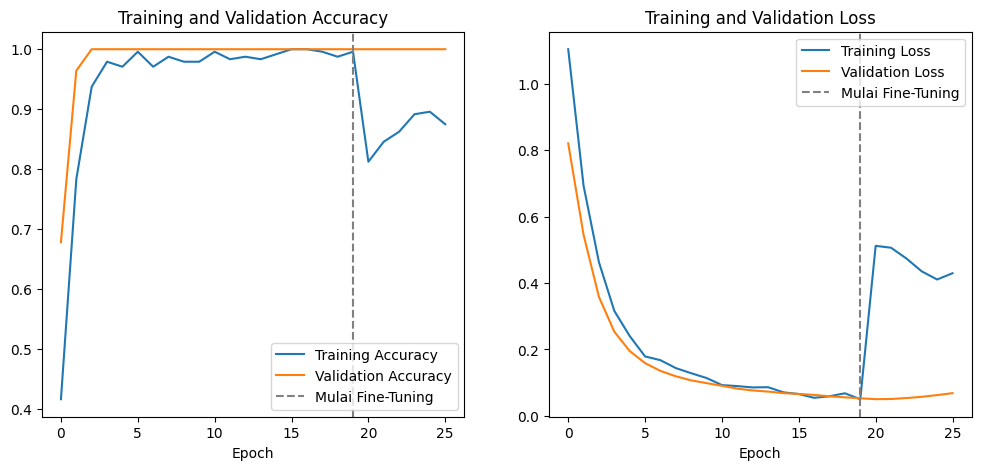

In [14]:
# Gabungkan history dari kedua tahap pelatihan
acc = history.history['accuracy'] + history_fine_tune.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine_tune.history['val_accuracy']
loss = history.history['loss'] + history_fine_tune.history['loss']
val_loss = history.history['val_loss'] + history_fine_tune.history['val_loss']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(x=initial_epochs-1, color='gray', linestyle='--', label='Mulai Fine-Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=initial_epochs-1, color='gray', linestyle='--', label='Mulai Fine-Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')

plt.show()

### Evaluasi Final

In [15]:
print("Mengevaluasi model pada set data pengujian...")
loss, accuracy = model.evaluate(test_ds)
print(f"Akurasi pada data test: {accuracy:.2%}")

Mengevaluasi model pada set data pengujian...


2025-06-23 14:42:24.366815: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-06-23 14:42:24.366966: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step - accuracy: 1.0000 - loss: 0.0481
Akurasi pada data test: 100.00%


### Menganalisis kesalahan dengan Confusion Matrix

2025-06-23 14:42:25.271918: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-06-23 14:42:25.272060: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-06-23 14:42:25.735498: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 100663296 bytes after encountering the first element of size 100663296 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ra

Classification Report:

              precision    recall  f1-score   support

        batu       1.00      1.00      1.00         8
        kain       1.00      1.00      1.00        10
        kayu       1.00      1.00      1.00        14

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



2025-06-23 14:42:27.721086: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


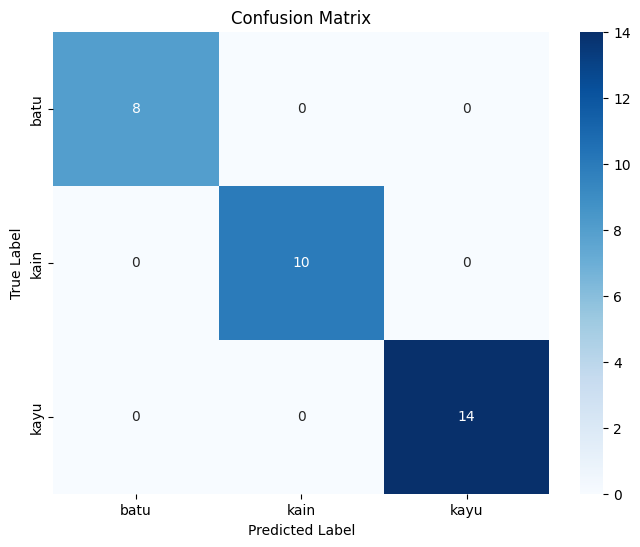

In [16]:
# Dapatkan prediksi dan label asli dari set test
y_pred = []
y_true = []
for image_batch, label_batch in test_ds:
   y_true.extend(label_batch.numpy())
   preds = model.predict(image_batch, verbose=0)
   y_pred.extend(np.argmax(preds, axis=-1))

# Tampilkan Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=CLASSES))

# Buat dan tampilkan Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Informasi misklasifikasi gambar dari Confusion Matrix

In [17]:
# Pastikan variabel-variabel ini sudah ada dari sel sebelumnya
# y_true, y_pred, test_ds, dan CLASSES

print("Mencari dan menampilkan gambar yang salah diklasifikasikan...")
print("-" * 50)

# Langkah 1: Kita perlu mengakses gambar satu per satu, bukan per batch.
# Kita "unbatch" dataset tes dan mengubahnya menjadi list agar mudah diakses.
images_and_labels_list = list(test_ds.unbatch().as_numpy_iterator())
validation_filepaths = initial_val_ds.file_paths
num_test_images = len(y_true)
test_filepaths = validation_filepaths[:num_test_images]

# Langkah 2: Iterasi melalui semua prediksi untuk menemukan yang salah
misclassified_found = False
for i in range(len(y_true)):
    # Cek jika prediksi tidak sama dengan label asli
    if y_true[i] != y_pred[i]:
        misclassified_found = True
        
        # Ambil gambar dari list dan nama filenya
        image, label = images_and_labels_list[i]
        filename = os.path.basename(test_filepaths[i])
        
        # Tampilkan gambar beserta nama filenya
        plt.figure(figsize=(6, 6))
        plt.imshow(image.astype("uint8"))
        plt.title(
            f"File: {filename}\n"
            f"Label Asli: {CLASSES[y_true[i]]}\n"
            f"Prediksi Model: {CLASSES[y_pred[i]]}",
            color='red'
        )
        plt.axis('off')
        plt.show()

if not misclassified_found:
    print("Selamat! Tidak ada gambar yang salah diklasifikasikan.")

Mencari dan menampilkan gambar yang salah diklasifikasikan...
--------------------------------------------------
Selamat! Tidak ada gambar yang salah diklasifikasikan.


2025-06-23 14:42:28.167054: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-06-23 14:42:28.167227: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 134217984 bytes after encountering the first element of size 134217984 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


## Save the trained model

In [18]:
# Save the best model
model.save('texture_model.keras')
print("Model saved successfully to 'texture_model.keras'")

Model saved successfully to 'texture_model.keras'
